## Take a good look

As WAV was one of the simplest ways to hold an audio file, bitmaps are one of the simplest ways to hold an image file. Like WAV, there's no compression, lossy or otherwise.

## Context: What is stored?

If you have sight, it's probably one of your most prominent senses. Eyes tell us all about our environment. It was natural that computers would go beyond text to show images.

Our eyes and cameras see light as it hits a plane. We have no real idea where the photons are going, just what their wavelength are and where they hit. So each of our eyes and a single camera will see a plane of wavelengths.

While our audio files map out a single signal over one dimension, times the number of channels, images are a two dimensional signal best mapped on a grid. Further, there's the question of storing color in each cell of this grid. And in a sense, there's another level of depth in terms of the number of bits that go into describing the color in each cell. The number of colors one pixel can depict is a matter of "bit depth."

Color space is its own issue. While we can imagine most colors as a mixture of red, green, and blue light, and easily store color as three channels of color, we do not percieve all colors equally. Further, in low light, we percieve less color, and in near-darkness, we barely percieve color at all, because our retina's monochromatic rod cells function in low light unlike our color-sensitive cone cells.

Here is a chart of where are eyes are most and least sensitive to color, assuming you aren't colorblind. [Courtesy of Wikimedia](https://en.wikipedia.org/wiki/File:Eyesensitivity.svg).

![img](https://i.imgur.com/WF1fIJj.png)

As you can see, our eyes are most attuned to greens, and less to more violet and red shades. From an evolutionary perspective, it's speculated this is to do with the importance of distinguishing plants in a prehistoric environment. But this is a blogpost about image formats and not how we evolved to be the smartest apes.

In addition, color space can also hold an alpha channel, which explains how translucent a pixel should be. This matters if you're drawing the image over a background, or working in a graphics program with layers.

But the past two paragraphs aren't extremely relevant here. But imagine how this knowledge could make a more compact/effective image format.

Rather, what bitmap formats do is keep a list of the color for each pixel. They can either write the entire color value (with a value for red, green, and blue intensity in a color image), or in some cases they use a color map. A colormap is a lookup table for each color used in the image, with the index standing in for the color. This saves some space if there's repetition in the color values. That means a single integer stands in for what would be a three or four integer structure. It reminds me a bit of the [palette systems older video game consoles used](https://en.wikipedia.org/wiki/List_of_video_game_console_palettes).

## The Metadata

For this article, we're looking at the somewhat obsolete TGA format. Microsoft's BMP format is more popular, but I found the header rather complicated, and I didn't want to focus on a bunch of fields to do with compressions and modes I wouldn't be discussing.

Let's look at TGA's header.

The fields are arranged like:

Index | Length | Name
--- | --- | --- 
1 | 1 | ID length
2 | 1 | Color Map Type
3 | 1 | Image Type
4 | 5 | Color Map Specification
5 | 10 | Image specification

Let's get into what these are:
* ID Length: The length of the ID field, which was often used for timestamps or some kind of serial number. A bit like a smaller version of EXIF data you find in newer image formats, but that's for later :)
* Color map type: A byte that's a boolean for if the image has a color map (0 means no color map, 1 means there is one), and other values were reserved for extensions by TrueVision or developers.
* Image Type: TGA supports a few different encodings and color spaces, as well as some very basic compression. This shares the size of each color and how to go about decoding the image. It even supports a file with no image data, 0. That surprises me, but I guess it might have come in handy in graphics software that needed placeholder files? If anybody knows, message me! 
    * 0 No image
    * 1 Uncompressed color mapped
    * 2 Uncompressed true color image
    * 3 Uncompressed grayscale
    * 9 Run-length encoded color-mapped image
    * 10 Run-length encoded true-color image
    * 11 Run-length encoded grayscale image
> Digression: Run-length encoding is a lossless and simple compression scheme where repeating consecutive values are not repeated, but stored once with a multiplier. So in a string, "baaaaaaaaaaanana" would become "ba(11)nana."
* Color map specification: Has three fields in itself

Index | Length (bytes) | Name | Description
--- | --- | --- | ---
1 | 2 | Index | The first entry in the color map is at this byte index
2 | 2 | Length | The length of the color map in bytes
3 | 1 | Entry Size | The number of bits in each pixel

* Image specification: Contains the x-origin (2 bytes), the y-origin (2 bytes), image width and height (2 bytes each), pixel depth, and image descriptor.

After that, we optionally have the image ID, and we optionally have the colormap, and finally the image data.

## The data

Without run-length encoding, what occurs as the actual content is some mixture of colors. Those colors are either specified everytime without a colormap, OR they are a value to be looked up in the colormap.

To place the pixels, the image is stored as a flattened 2d array. So, to access a pixel from an array, you would access it like `image_bytes[(y * width) + x]`.

## Making a picture

Let's try to encode an image from scratch.

The simplest possible image I can think of that isn't just blank would be a single pixel color, repeated. Let's encode that and move on to bigger things.

In [54]:
import struct

# Make a bytestring to start a 100x100 True Color TGA file
def make_header():
    buf = bytearray()
    # add ID length, 0 as we will not use one
    buf.append(0)
    # no colormap
    buf.append(0)
    # Image type - uncompressed true color image
    buf.append(2)
    # Colormap is null, just five empty bytes
    buf.extend(b"\x00" * 5)
    # x origin and y origin, both 0 as a 2-byte integer
    buf.extend(b"\x00" *2)
    buf.extend(b"\x00" *2)
    # width and height
    buf.extend(struct.pack("H", 100))
    buf.extend(struct.pack("H", 100))
    # bits per pixel, 24 bits AKA 18 in hex
    buf.extend(b"\x18")
    # info about alpha, 0
    buf.extend(b"\x00")
    return buf

def make_green_tga(header):
    buf = header
    # BEGIN BITMAP
    for _ in range(10000):
        # Pix 1: Blue
        buf.extend(b"\x50")
        # Pix 2: Green
        buf.extend(b"\xAA")
        # Pix 3: Red
        buf.extend(b"\x50")
    return buf

buf = make_green_tga(make_header())
with open("pixel.tga", "wb") as f:
    f.write(buf)

In [55]:
# Sadly, we must convert the TGA to a PNG so that Jupyter Notebooks can display our data
!convert pixel.tga pixel.png

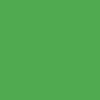

In [56]:
from IPython.display import Image 
Image(filename='pixel.png')

It works! For fun, let's do some kind of gradient function.

In [57]:
buf = make_header()
for y in range(100):
    for x in range(100):
        buf.extend(struct.pack("BBB", x*2, y*2, abs(x-y)*2))
with open("img2.tga", "wb") as f:
    f.write(buf)

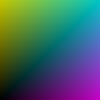

In [58]:
!convert img2.tga img2.png
Image(filename="img2.png")

Well, that's fun.

Let's see what happens with a photograph represented as a TGA. TGA isn't at all a bad format for photos if storage space isn't a concern, because it supports a good amount of colors.

But what should the photograph be of? Is there any person, place, or thing worthy of this format? Ideally with some detail and starpower?

![img](http://i.imgur.com/vB6sXoK.png)

In that case, we have no choice but to use a TGA of Jeff Goldblum, instead of a Playboy model like so many other grapics tutorials/demos use.

![img](https://i.imgur.com/M2LnIvU.jpg)

I'm going to convert this to a TGA like the one we created ourselves, and compare it to the JPG of Goldblum I got off the web.

In [59]:
!convert handsome_devil.jpg handsome_devil.tga

# How big is he?!
# as a compressed image
!du -h handsome_devil.jpg
!du -h handsome_devil.tga

32K	handsome_devil.jpg
704K	handsome_devil.tga


So, a JPEG is about 1/20th the size of a simple list of pixel values! How do they pull that off? There's some fascinating lossy compression going on, but that is for a future post.

Next up, let's look at how lossy compression for a one-dimensional signal would work. That's right, we're shrinking audio files next post!